<a href="https://colab.research.google.com/github/quickgrid/CodeLab/blob/master/dataset/albumentations_imgaug_object_detection_bounding_box_augmentation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get a sample image

In [1]:
!wget "https://upload.wikimedia.org/wikipedia/commons/b/b9/CyprusShorthair.jpg" -O "cat1.jpg"

--2021-01-11 08:14:36--  https://upload.wikimedia.org/wikipedia/commons/b/b9/CyprusShorthair.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 339455 (331K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 331.50K  --.-KB/s    in 0.02s   

2021-01-11 08:14:36 (15.9 MB/s) - ‘cat1.jpg’ saved [339455/339455]



# Install albumentations and imgaug

In [2]:
!pip install --upgrade imgaug

     |████████████████████████████████| 952kB 12.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [3]:
!pip install --upgrade albumentations

     |████████████████████████████████| 81kB 4.3MB/s 
     |████████████████████████████████| 37.6MB 1.1MB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Perform image augmentations with albumentations

In [1]:
from matplotlib import pyplot as plt

def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

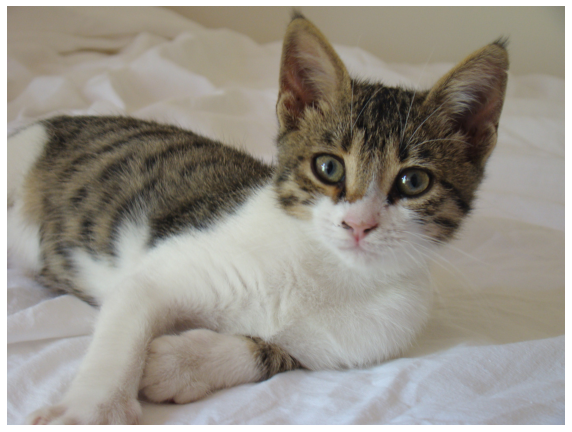

In [2]:
import albumentations as A
import cv2
from IPython.display import Image
import random


# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("cat1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

visualize(image) 

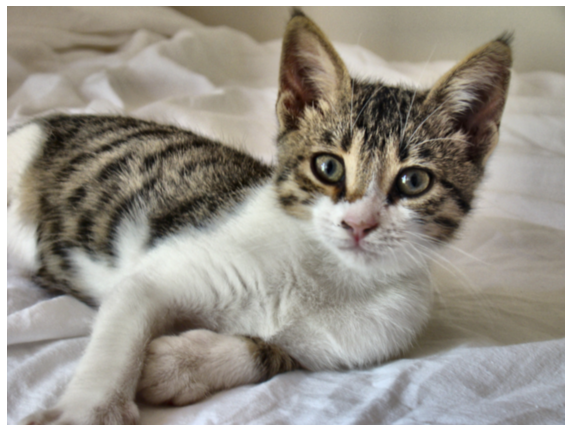

In [3]:
transform = A.Compose([
    A.CLAHE(),
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
])
random.seed(42) 
augmented_image = transform(image=image)['image']
visualize(augmented_image)

In [4]:
bboxes = [
    [450, 74, 900, 500]
]

class_labels = ['cat']

[[450, 74, 900, 500]]


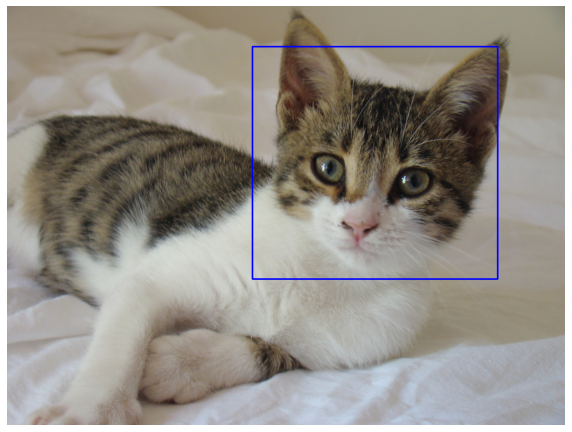

In [5]:
bbox_img = image.copy()
cv2.rectangle(bbox_img, (bboxes[0][0], bboxes[0][1]), (bboxes[0][2], bboxes[0][3]), (0,0,255), 2)
visualize(bbox_img)
print(bboxes)

[(124.0, 74.0, 574.0, 500.0)]


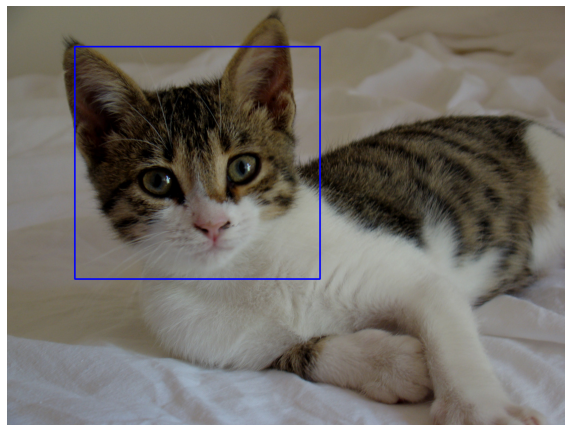

In [9]:
## In pascal voc format

transform = A.Compose([
    #A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=1.0),
    A.RandomBrightnessContrast(p=0.9),
], bbox_params=A.BboxParams(format='pascal_voc', min_area=64, min_visibility=0.1, label_fields=['class_labels']))

transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']


#visualize(transformed_image)

bbox_img = transformed_image.copy()
cv2.rectangle(bbox_img, (int(transformed_bboxes[0][0]), int(transformed_bboxes[0][1])), (int(transformed_bboxes[0][2]), int(transformed_bboxes[0][3])), (0,0,255), 2)
visualize(bbox_img)
print(transformed_bboxes)

# Perform image augmentations with imgaug

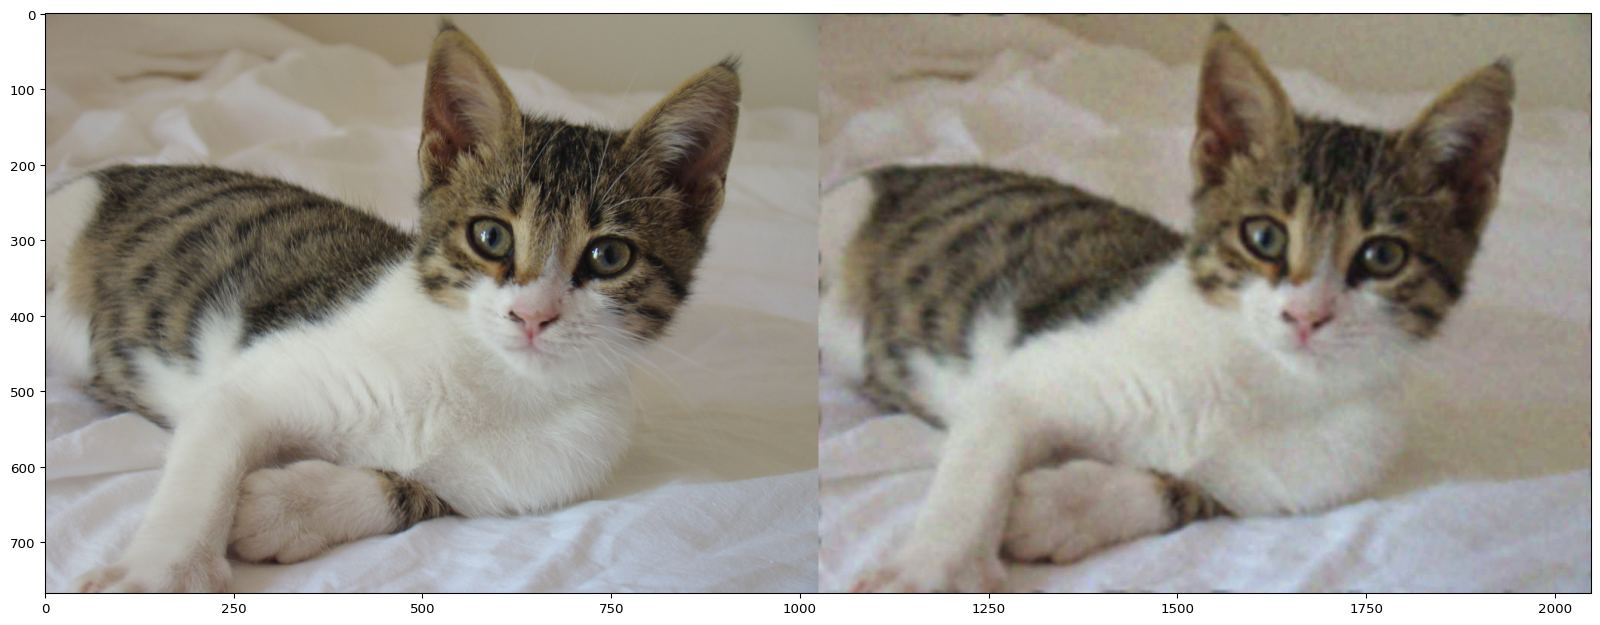

In [10]:
import cv2
import imgaug as ia
import numpy as np
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


seq = iaa.Sequential([
    iaa.JpegCompression(compression=(90, 49)),
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.AddElementwise((-40, 40),per_channel=0.5),
    iaa.AddToHueAndSaturation((-20, 20)),  
    iaa.ElasticTransformation(alpha=30, sigma=9),  
], random_order=True)

images_aug = seq(image=image)

ia.imshow(np.hstack([image, images_aug]))

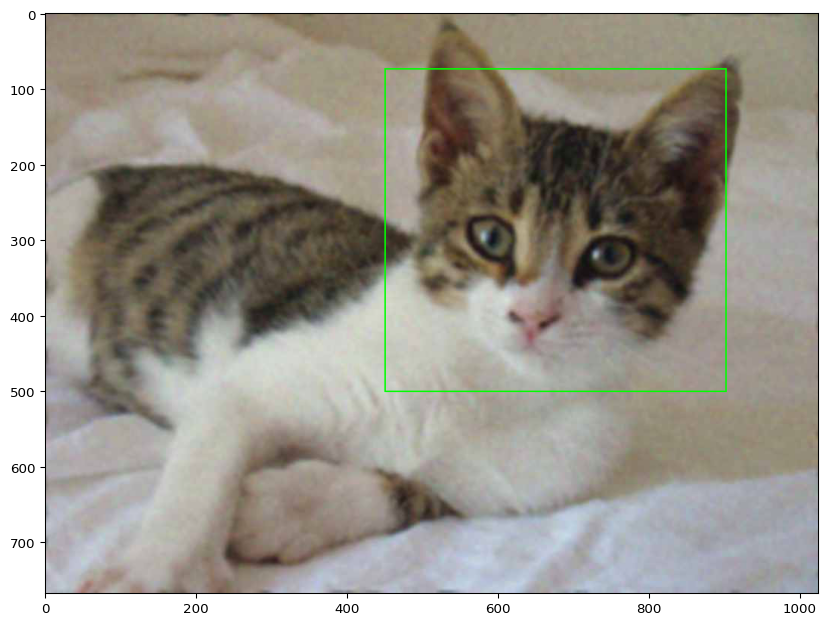

In [11]:
x1, x2, y1, y2 = bboxes[0]
bbox_img = images_aug.copy()

bbs = BoundingBoxesOnImage([
    BoundingBox(x1, x2, y1, y2)
    ], shape=image.shape)
ia.imshow(bbs.draw_on_image(bbox_img, size=2))

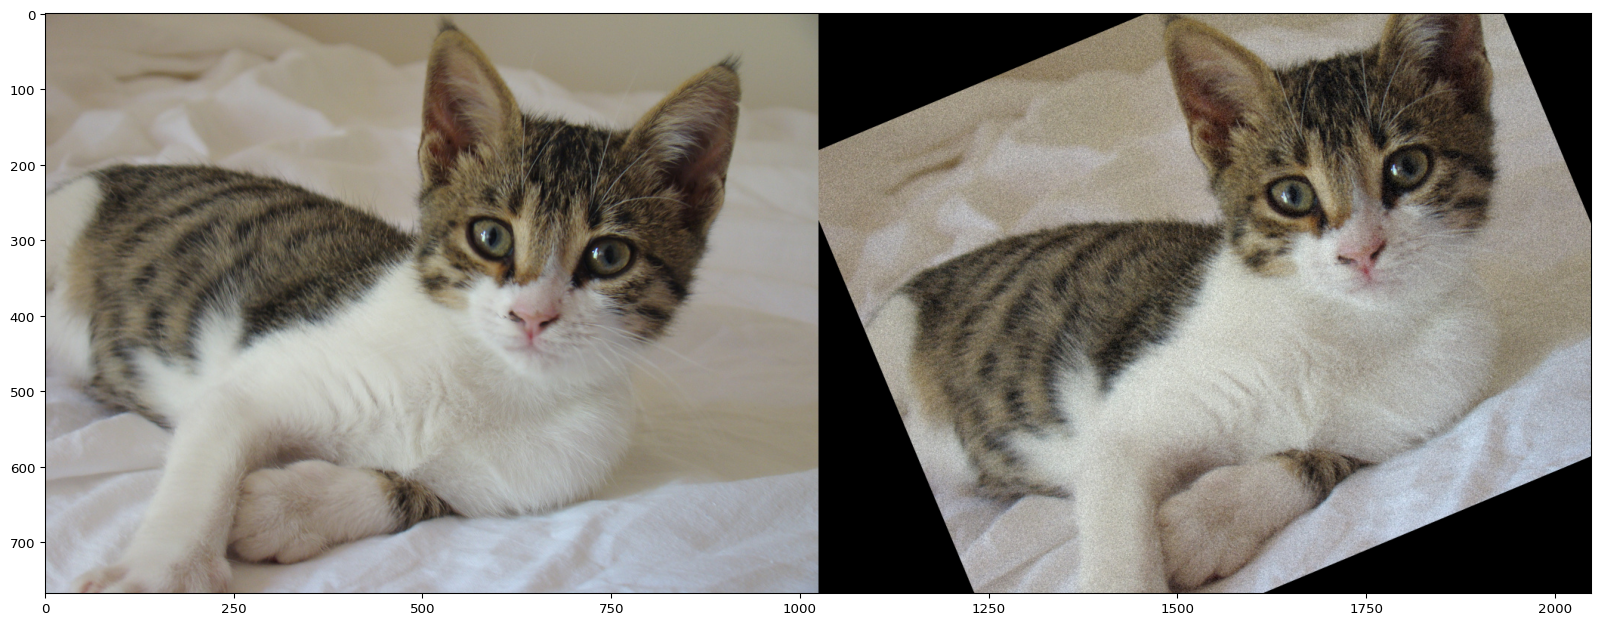

BoundingBoxesOnImage([BoundingBox(x1=411.0438, y1=-83.1232, x2=990.4146, y2=483.3445, label=None)], shape=(768, 1024, 3))


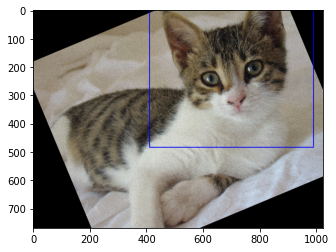

In [12]:
seq = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=0.05*255),
    iaa.Affine(translate_px={"x": (100, 25)}),
    iaa.Affine(rotate=(-45, 45))
])

images_aug1, bbs_aug = seq(image=image, bounding_boxes=bbs)


ia.imshow(np.hstack([image, images_aug1]))
print(bbs_aug)


bbox_img = images_aug1.copy()
cv2.rectangle(bbox_img, (int(bbs_aug[0].x1), int(bbs_aug[0].y1)), (int(bbs_aug[0].x2), int(bbs_aug[0].y2)), (0,0,255), 2)
plt.imshow(bbox_img)
plt.show()